# Common statistical tests are linear models (or: how to teach stats)

By Jonas Kristoffer Lindeløv ([blog](https://lindeloev.net), [profile](http://personprofil.aau.dk/117060)).
Python port by George Ho ([blog](https://eigenfoo.xyz)).

In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

print("Last updated: {}".format(datetime.datetime.now().strftime("%B %d, %Y")))

Last updated: June 24, 2019


# The simplicity underlying common tests

Most of the common statistical models (t-test, correlation, ANOVA; chi-square, etc.) are special cases of linear models or a very close approximation. This beautiful simplicity means that there is less to learn. In particular, it all comes down to $y = a \cdot x + b$ which most students know from highschool. Unfortunately, stats intro courses are usually taught as if each test is an independent tool, needlessly making life more complicated for students and teachers alike. 

This needless complexity multiplies when students try to rote learn the parametric assumptions underlying each test separately rather than deducing them from the linear model.

For this reason, I think that teaching linear models first and foremost and *then* name-dropping the special cases along the way makes for an excellent teaching strategy, emphasizing *understanding* over rote learning. Since linear models are the same across frequentist, Bayesian, and permutation-based inferences, I'd argue that it's better to start with modeling than p-values, type-1 errors, Bayes factors, or other inferences.

Concerning the teaching of *"non-parametric"* tests in intro-courses, I think that we can justify [lying-to-children](https://en.wikipedia.org/wiki/Lie-to-children) and teach "non-parametric"" tests as if they are merely ranked versions of the corresponding parametric tests. It is much better for students to think "ranks!" than to believe that you can magically throw away assumptions. Indeed, the Bayesian equivalents of "non-parametric"" tests implemented in [JASP](https://jasp-stats.org) [literally just do (latent) ranking](https://arxiv.org/abs/1712.06941) and that's it. For the frequentist "non-parametric"" tests considered here, this approach is highly accurate for N > 15.

Use the menu to jump to your favourite section. There are links to lots of similar (though more scattered) stuff under [sources](#links) and [teaching materials](#course). I hope that you will join in suggesting improvements or submitting improvements yourself in [the Github repo to this page](https://github.com/lindeloev/tests-as-linear). Let's make it awesome!

# Settings and toy data

In [2]:
# Reproducible results
np.random.seed(1859)

# TODO any plt stuff, possibly in a function?

In [3]:
df = pd.DataFrame()
df["x"] = np.random.normal(loc=0.0, scale=1.0, size=50)  # Used in correlation where this is on x-axis
df["y"] = np.random.normal(loc=0.3, scale=2.0, size=50)  # Almost zero mean
df["y2"] = np.random.normal(loc=0.5, scale=1.5, size=50)  # Used in two means

df.head()

,x,y,y2
0,-0.519600,0.468526,1.634513
1,0.748846,-1.061492,-1.218693
2,-1.411567,0.995318,0.185277
3,-0.416355,1.839929,2.944933
4,0.943077,1.265272,-1.159019


# Pearson and Spearman correlation

## Theory: As linear models 

Model: the recipe for $y$ is a slope ($\beta_1$) times $x$ plus an intercept ($\beta_0$, aka a straight line).


$y = \beta_0 + \beta_1 x \qquad \mathcal{H}_0: \beta_1 = 0$

... which is a math-y way of writing the good old $y = ax + b$ (here ordered as $y = b + ax$). In R we are lazy and write `y ~ 1 + x` which R reads like `y = 1*number + x*othernumber` and the task of t-tests, lm, etc., is simply to find the numbers that best predict $y$.

Either way you write it, it's an intercept ($\beta_0$) and a slope ($\beta_1$) yielding a straight line:

In [4]:
# Correlated data with fixed correlation
correlated_data = pd.DataFrame()
correlated_data["x"], correlated_data["y"] = \
    np.random.multivariate_normal(mean=[0.9, 0.9],
                                  cov=np.array([1, 0.8, 0.8, 1]).reshape(2, 2),
                                  size=30).transpose()

In [5]:
res = smf.ols(formula="y ~ 1 + x", data=correlated_data).fit()
intercept, slope = res.params

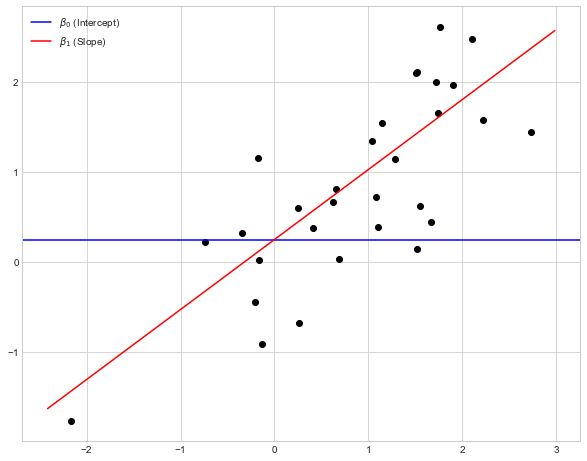

In [6]:
fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(correlated_data["y"], correlated_data["x"], color="k")
ax.axhline(intercept, color="b", label=r"$\beta_0$ (Intercept)")
ax.plot(ax.get_xlim(), [slope*x + intercept for x in ax.get_xlim()],
        color="r", label=r"$\beta_1$ (Slope)")
ax.legend();

This is often simply called a **regression** model which can be extended to **multiple regression** where there are several $\beta$s and on the right-hand side multiplied with the predictors. Everything below, from [one-sample t-test](#t1) to [two-way ANOVA](#anova2) are just special cases of this system. Nothing more, nothing less.

As the name implies, the **Spearman rank correlation** is a **Pearson correlation** on rank-transformed $x$ and $y$:

$\text{rank}(y) = \beta_0 + \beta_1 \cdot \text{rank}(x) \qquad \mathcal{H}_0: \beta_1 = 0$

I'll introduce [ranks](#Theory:-rank-transformation) in a minute. For now, notice that the correlation coefficient of the linear model is identical to a "real" Pearson correlation, but p-values are an approximation which is is [appropriate for samples greater than N=10 and almost perfect when N > 20](simulations/simulate_spearman.html).

Such a nice and non-mysterious equivalence that many students are left unaware of! Visualizing them side by side including data labels, we see this rank-transformation in action:

In [7]:
ranked_data = np.argsort(correlated_data, axis=0)
res = smf.ols(formula="y ~ 1 + x", data=ranked_data).fit()
intercept_spearman, slope_spearman = res.params

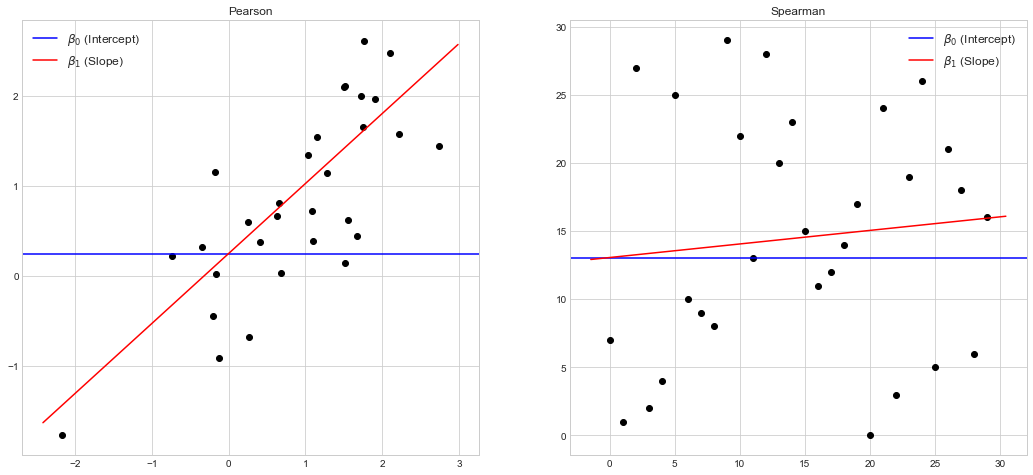

In [8]:
fig, axarr = plt.subplots(ncols=2, figsize=[18, 8])

for ax, data, title, a, b in zip(axarr, [correlated_data, ranked_data],
                           ["Pearson", "Spearman"], [intercept, intercept_spearman], [slope, slope_spearman]):
    ax.set_title(title)
    ax.scatter(data["y"], data["x"], color="k")
    ax.axhline(a, color="b", label=r"$\beta_0$ (Intercept)")
    ax.plot(ax.get_xlim(), [b*x + a for x in ax.get_xlim()], color="r", label=r"$\beta_1$ (Slope)")
    ax.legend(fontsize="large")

## Theory: rank-transformation

`np.argsort` simply takes a list of numbers and "replaces" them with the integers of their rank (1st smallest, 2nd smallest, 3rd smallest, etc.). So the result of the rank-transformation `np.argsort([3.6, 3.4, -5.0, 8.2])` is `[3, 2, 1, 4]`. See that in the figure above? 

A *signed* rank is the same, just where we rank according to absolute size first and then add in the sign second. So the signed rank here would be `[2, 1, -3, 4]`. Or in code:

```python
def signed_rank(x):
    return np.sign(x) * np.argsort(x)
```

I hope I don't offend anyone when I say that ranks are easy; yet it's all you need to do to convert most parametric tests into their "non-parametric" counterparts! One interesting implication is that *many "non-parametric tests" are about as parametric as their parametric counterparts with means, standard deviations, homogeneity of variance, etc. - just on rank-transformed data*. That's why I put "non-parametric" in quotation marks.

## Python code: Pearson correlation

It couldn't be much simpler to run these models in R. They yield identical `p` and `t`, but there's a catch: `lm` gives you the *slope* and even though that is usually much more interpretable and informative than the *correlation coefficient* *r*, you may still want *r*. Luckily, the slope becomes `r` if `x` and `y` have a standard deviation of exactly 1. You can do this using `scale(x)` or `I(x/sd(x))`:

In [9]:
scaled_data = correlated_data / correlated_data.std()

res1 = smf.ols(formula="y ~ 1 + x", data=correlated_data).fit()
res2 = smf.ols(formula="y ~ 1 + x", data=scaled_data).fit()

## Python code: Spearman correlation

Note that we can interpret the slope which is the number of ranks $y$ change for each rank on $x$. I think that this is a pretty interesting number. However, the intercept is less interpretable since it lies at $rank(x) = 0$ which is impossible since x starts at 1.

See the identical `r` (now "rho") and `p`:

In [10]:
ranked_data = np.argsort(correlated_data, axis=0)

res = smf.ols(formula="y ~ 1 + x", data=ranked_data).fit()

Let's look at the results:

In [11]:
# TODO

# One mean

## One sample t-test and Wilcoxon signed-rank

### Theory: As linear models

**t-test** model: A single number predicts $y$.

$y = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

In other words, it's our good old $y = \beta_0 + \beta_1*x$ where the last term is gone since there is no $x$ (essentially $x=0$, see left figure below).

The same is to a very close approximately true for **Wilcoxon signed-rank test**, just with the [signed ranks](#rank) of $y$ instead of $y$ itself (see right panel below).

$\text{signed_rank}(y) = \beta_0$

[This approximation is good enough when the sample size is larger than 14 and almost perfect if the sample size is larger than 50](simulations/simulate_wilcoxon.html).

In [12]:
# TODO make plot